# Linear Regression Analysis for Used Car Prices (Version 2)

## Import Necessary Libraries

In [21]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
    

## Load the Dataset

In [22]:

# Load the dataset
data = pd.read_csv("data/vehicles.csv")

# Display dataset info
print("Dataset Information:")
print(data.info())
print("First few rows:")
print(data.head())
    

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-nu

## Missing Value Analysis

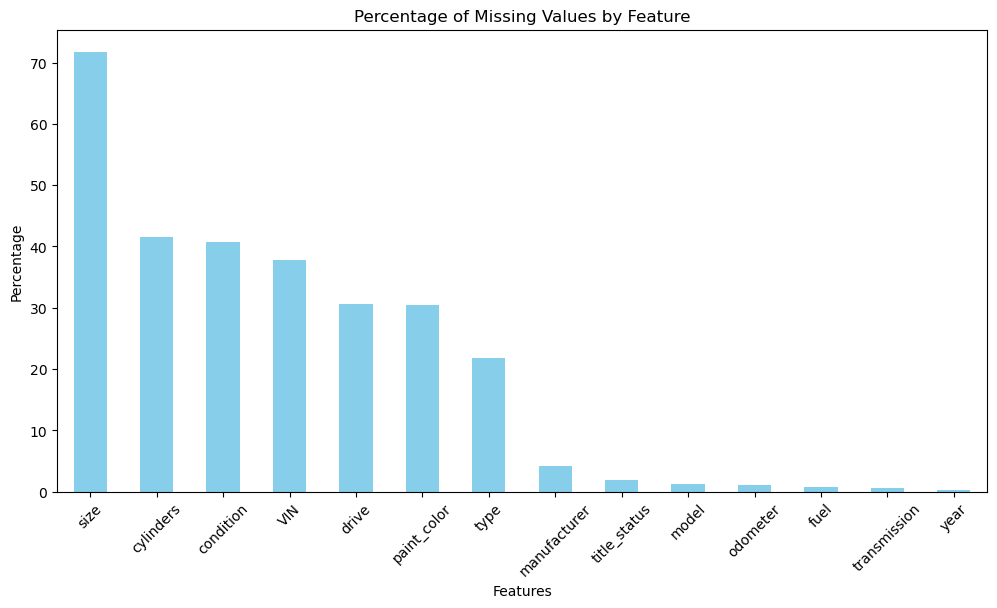

In [23]:

# Calculate percentage of missing values
missing_percentage = data.isnull().mean() * 100

# Plot missing values
plt.figure(figsize=(12, 6))
missing_percentage[missing_percentage > 0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Percentage of Missing Values by Feature")
plt.ylabel("Percentage")
plt.xlabel("Features")
plt.xticks(rotation=45)
plt.show()
    

## Handle Missing Data

In [24]:

features_with_less_na = missing_percentage[missing_percentage < 5].index
data_filtered = data[features_with_less_na]
data_cleaned = data_filtered.dropna()

# Drop high-character features to avoid memory issues
data_cleaned = data_cleaned.drop(columns=['model', 'region'], errors='ignore')
    

## Frequency Encoding for Categorical Features

In [25]:

# Frequency encoding for categorical features
for col in ['state', 'manufacturer']:
    if col in data_cleaned.columns:
        data_cleaned[f'{col}_freq'] = data_cleaned[col].map(data_cleaned[col].value_counts())
data_cleaned = data_cleaned.drop(columns=['state', 'manufacturer'], errors='ignore')
    

## Visualize Outliers in the Price Feature

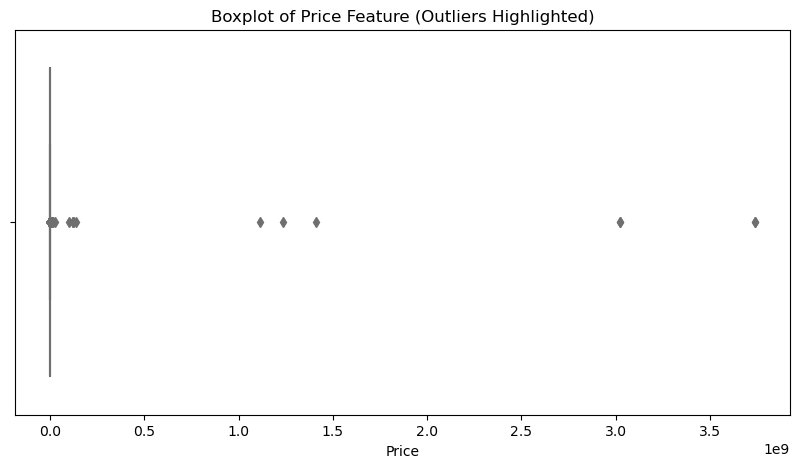

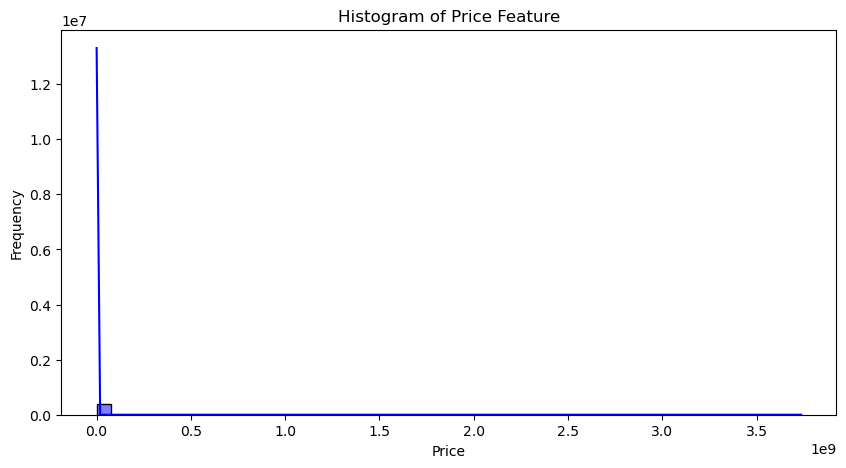

In [26]:

# Boxplot for price feature
plt.figure(figsize=(10, 5))
sns.boxplot(x=data_cleaned['price'], color='skyblue')
plt.title("Boxplot of Price Feature (Outliers Highlighted)")
plt.xlabel("Price")
plt.show()

# Histogram for price feature
plt.figure(figsize=(10, 5))
sns.histplot(data_cleaned['price'], bins=50, kde=True, color='blue')
plt.title("Histogram of Price Feature")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()
    

## Remove Outliers in Price

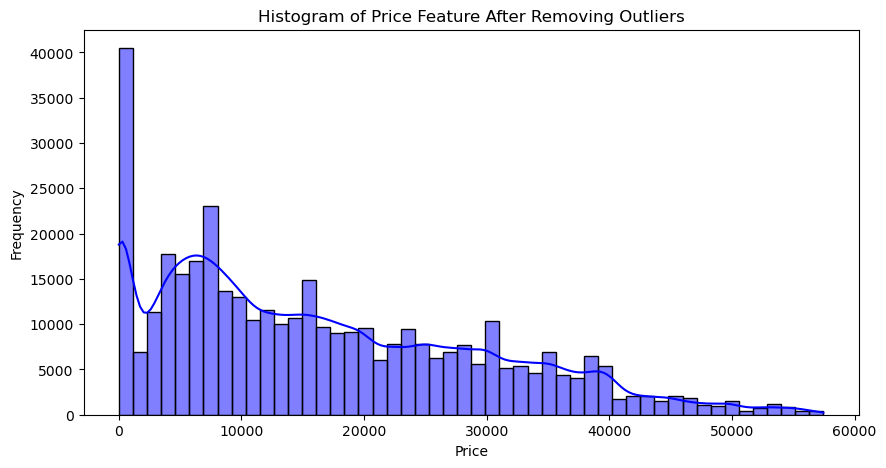

In [27]:

# Remove extreme outliers in the target variable
q1 = data_cleaned['price'].quantile(0.25)
q3 = data_cleaned['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data_cleaned = data_cleaned[(data_cleaned['price'] >= lower_bound) & (data_cleaned['price'] <= upper_bound)]

# Histogram for price feature after outlier removal
plt.figure(figsize=(10, 5))
sns.histplot(data_cleaned['price'], bins=50, kde=True, color='blue')
plt.title("Histogram of Price Feature After Removing Outliers")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()
    

## Perform One-Hot Encoding

In [28]:

# Perform one-hot encoding on remaining categorical features
categorical_features = data_cleaned.select_dtypes(include=['object']).columns
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_features, drop_first=True)
    

## Correlation Matrix for Features and Price

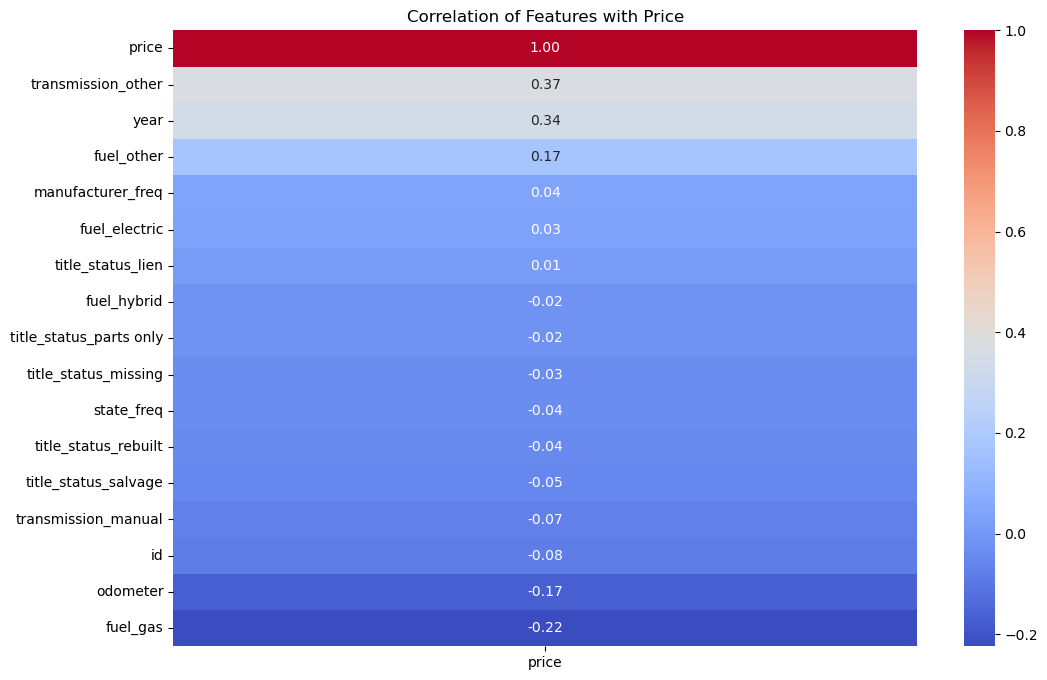

In [29]:

# Compute correlation matrix
correlation_matrix = data_encoded.corr()

# Plot the heatmap for correlation between features and price
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['price']].sort_values(by='price', ascending=False), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation of Features with Price")
plt.show()
    

## Define Features and Target

In [30]:

# Define features (X) and target (y)
X = data_encoded.drop(columns=['price'], errors='ignore')  # Features
y = data_encoded['price']  # Target

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Scale the target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()
    

## Train-Test Split

In [31]:

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")
    

Training set shape: X=(306358, 16), y=(306358,)
Test set shape: X=(76590, 16), y=(76590,)


## Train Linear Regression Model

In [32]:

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"Linear Regression Model Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
    

Linear Regression Model Performance:
RMSE: 0.86
MAE: 0.66


## Cross-Validation

In [33]:

# Define custom scorers for MSE and MAE
mse_scorer = make_scorer(mean_squared_error)
mae_scorer = make_scorer(mean_absolute_error)

# Perform cross-validation for MSE and MAE
mse_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring=mse_scorer)
mae_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring=mae_scorer)

# Display cross-validation results
print(f"Cross-Validation MSE (mean): {mse_scores.mean():.2f}, (std): {mse_scores.std():.2f}")
print(f"Cross-Validation MAE (mean): {mae_scores.mean():.2f}, (std): {mae_scores.std():.2f}")
    

Cross-Validation MSE (mean): 0.74, (std): 0.00
Cross-Validation MAE (mean): 0.66, (std): 0.00


## Ridge and Lasso Regression with Grid Search

In [34]:
#I tried to run the grdi Search but was getting NaN values for the analysis, hence didn't use it for prediction, and Have attached in the end section

# Define parameter grids for Ridge and Lasso
ridge_param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}

# Grid search for Ridge Regression
ridge = Ridge()
ridge_grid_search = GridSearchCV(ridge, ridge_param_grid, scoring=mse_scorer, cv=5)
ridge_grid_search.fit(X_train, y_train)

# Grid search for Lasso Regression
lasso = Lasso()
lasso_grid_search = GridSearchCV(lasso, lasso_param_grid, scoring=mae_scorer, cv=5)
lasso_grid_search.fit(X_train, y_train)

# Display best parameters and scores
print(f"Best Ridge Parameters: {ridge_grid_search.best_params_}")
print(f"Best Ridge RMSE: {np.sqrt(ridge_grid_search.best_score_):.2f}")

print(f"Best Lasso Parameters: {lasso_grid_search.best_params_}")
print(f"Best Lasso RMSE: {np.sqrt(lasso_grid_search.best_score_):.2f}")
    

Best Ridge Parameters: {'alpha': 0.001}
Best Ridge RMSE: 0.86
Best Lasso Parameters: {'alpha': 1}
Best Lasso RMSE: 0.91


## Interpret Linear Regression Coefficients

In [35]:

# Interpret the coefficients from the linear regression model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Top Positive Features:")
print(coefficients.head(10))

print("Top Negative Features:")
print(coefficients.tail(10))
    

Top Positive Features:
                    Feature  Coefficient
15       transmission_other     0.301535
1                      year     0.260280
4         manufacturer_freq     0.085254
14      transmission_manual     0.032725
9         title_status_lien     0.016659
10     title_status_missing     0.002198
11  title_status_parts only    -0.008427
3                state_freq    -0.022653
12     title_status_rebuilt    -0.026405
13     title_status_salvage    -0.035689
Top Negative Features:
                    Feature  Coefficient
11  title_status_parts only    -0.008427
3                state_freq    -0.022653
12     title_status_rebuilt    -0.026405
13     title_status_salvage    -0.035689
5             fuel_electric    -0.035913
0                        id    -0.046253
2                  odometer    -0.087454
7               fuel_hybrid    -0.105784
8                fuel_other    -0.156649
6                  fuel_gas    -0.261772


## Scale Predictions Back and Evaluate

In [36]:

# Scale predictions back to the original price scale
y_pred_original = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_original = y_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Display the first few predictions alongside actual values
predictions_df = pd.DataFrame({
    'Actual Price': y_test_original,
    'Predicted Price': y_pred_original
})
print(predictions_df.head(10))

# Evaluate the model on the original scale
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae_original = mean_absolute_error(y_test_original, y_pred_original)

print(f"Evaluation on Original Price Scale:")
print(f"RMSE: ${rmse_original:.2f}")
print(f"MAE: ${mae_original:.2f}")
    

   Actual Price  Predicted Price
0       19450.0     19427.429025
1       19995.0     14191.220132
2        7995.0     16946.942822
3           0.0     14738.696612
4       11995.0     15767.967282
5        6200.0     12427.338184
6        7900.0     11440.948342
7           0.0     17925.718580
8       26712.0     16236.255524
9         683.0     25899.840449
Evaluation on Original Price Scale:
RMSE: $11247.70
MAE: $8625.51


## Interpret the coefficients from the linear regression model


Top Positive Features:
                    Feature  Coefficient
15       transmission_other     0.301535
1                      year     0.260280
4         manufacturer_freq     0.085254
14      transmission_manual     0.032725
9         title_status_lien     0.016659
10     title_status_missing     0.002198
11  title_status_parts only    -0.008427
3                state_freq    -0.022653
12     title_status_rebuilt    -0.026405
13     title_status_salvage    -0.035689
Top Negative Features:
                    Feature  Coefficient
11  title_status_parts only    -0.008427
3                state_freq    -0.022653
12     title_status_rebuilt    -0.026405
13     title_status_salvage    -0.035689
5             fuel_electric    -0.035913
0                        id    -0.046253
2                  odometer    -0.087454
7               fuel_hybrid    -0.105784
8                fuel_other    -0.156649
6                  fuel_gas    -0.261772


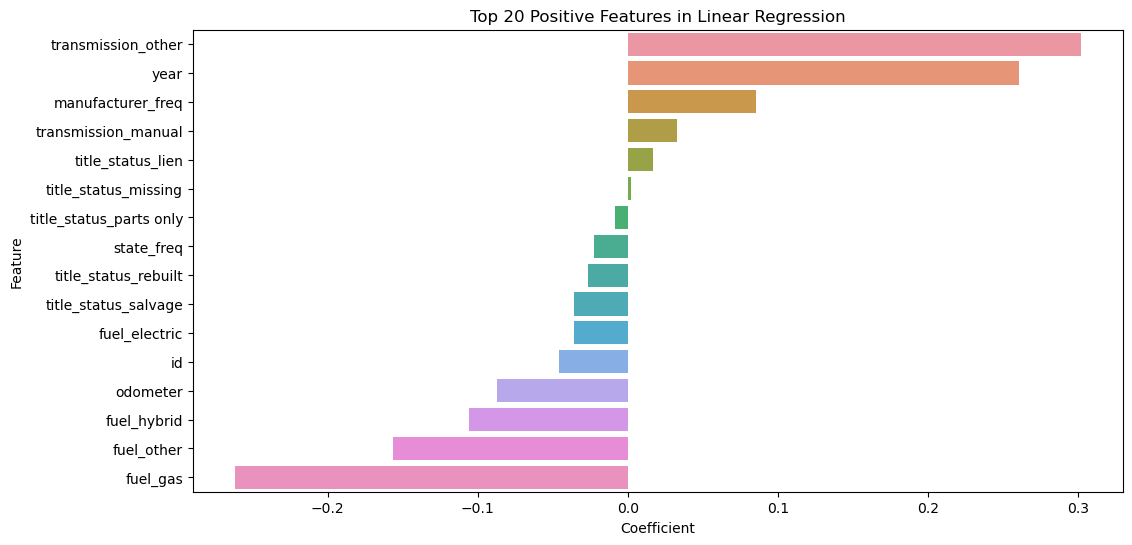

In [37]:


# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)  # Fit the model to the training data

# Extract and analyze coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Top Positive Features:")
print(coefficients.head(10))

print("Top Negative Features:")
print(coefficients.tail(10))

# Plot top coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients.head(20))
plt.title('Top 20 Positive Features in Linear Regression')
plt.show()



    